# Sail routing

In [80]:
import json
import datetime
import codecs

import numpy as np
import ipywidgets as widgets
from scipy.interpolate import LinearNDInterpolator
from scipy.optimize import minimize
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from dms2dec.dms_convert import dms2dec
from pyproj import Geod, enums

# Conversion between meters and nautical miles
NM = 1852.0

# Geodetic system
geoid = Geod(ellps="WGS84")


## Set up the map

In [81]:
# STARTING POSITION: Sassnitz
STA_LAT = dms2dec("""54°30'56.52" N""")
STA_LON = dms2dec("""13°38'40.24" E""")

# END POSITION: Roenne
END_LAT = dms2dec("""55°06'3.28" N""")
END_LON = dms2dec("""14°42'23.90" E""")

# Compute region of map
MIN_LON = min(STA_LON, END_LON) - 0.1 * abs(STA_LON - END_LON)
MIN_LAT = min(STA_LAT, END_LAT) - 0.1 * abs(STA_LAT - END_LAT)
MAX_LON = max(STA_LON, END_LON) + 0.1 * abs(STA_LON - END_LON)
MAX_LAT = max(STA_LAT, END_LAT) + 0.1 * abs(STA_LAT - END_LAT)

# Create map
m = Basemap(
    llcrnrlon=MIN_LON,
    llcrnrlat=MIN_LAT,
    urcrnrlon=MAX_LON,
    urcrnrlat=MAX_LAT,
    resolution="f",
    projection="merc",
)


## Wind 

In [82]:
def wind(lon, lat, time):
    return [(350 - time * 10) * np.ones_like(lon), (8 + 0.5 * time) * np.ones_like(lon)]


## Waypoints 

In [83]:
N = 10
wp = geoid.npts(STA_LON, STA_LAT, END_LON, END_LAT, N)
start = np.array([[STA_LON], [STA_LAT]])
end = np.array([[END_LON], [END_LAT]])

waypoints = np.array([[pos[0] for pos in wp], [pos[1] for pos in wp]])
full_waypoints = np.hstack([start, waypoints, end])

## Load polar chart

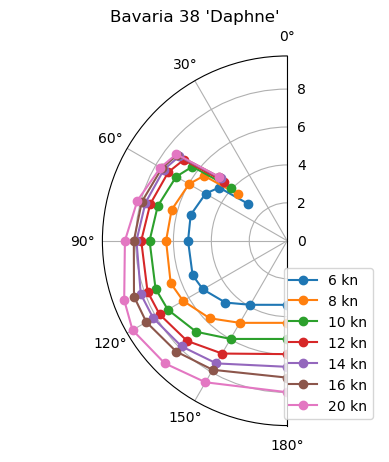

In [84]:
# Load boats
boats = json.load(codecs.open("boats.json", "r", "utf-8-sig"), strict=False)
boat = list(filter(lambda b: b["boat"]["type"] == "Bavaria 38", boats))[0]

# Align measured angles and wind speeds in a meshgrid for interpolation
min_angle = max(boat["vpp"]["beat_angle"])
max_angle = 180.0
a = np.array([min_angle] + boat["vpp"]["angles"] + [max_angle], dtype=float)
s = np.array(boat["vpp"]["speeds"], dtype=float)
angles, windspeeds = np.meshgrid(a, s)

# Fill table of velocities for interpolation
vel = np.zeros_like(angles)
vel[:, 0] = boat["vpp"]["beat_vmg"]
for i, angle in enumerate(boat["vpp"]["angles"]):
    vel[:, i + 1] = boat["vpp"][f"{angle}"]
vel[:, -1] = boat["vpp"]["run_vmg"]

# Build a look up table for interpolation of boat speed
lut = LinearNDInterpolator(
    list(zip(angles.ravel(), windspeeds.ravel())), vel.ravel(), fill_value=0.1
)

# Plot polar diagram of the boat
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_zero_location("N")
ax.set_thetamin(0)
ax.set_thetamax(180)
for a, v in zip(angles, vel):
    ax.plot(np.deg2rad(a), v, "o-")
plt.legend([f"{ws} kn" for ws in boat["vpp"]["speeds"]], loc="lower right")
plt.title(boat["boat"]["type"] + " '" + boat["name"] + "'")
plt.show()


In [85]:
def velocity(course, wind_dir, wind_mag):
    angle = np.abs(((course + 360.0) % 360.0 - wind_dir))
    if angle > 180:
        angle = 360.0 - angle
    return lut(angle, wind_mag)

## Compute travel time 

In [91]:
def compute_path(waypoints, start, end, opt=False):
    wpts = np.hstack([start, waypoints.reshape(2,-1), end])
    lons = wpts[0,:]
    lats = wpts[1,:]
    int_time = 0
    if not opt:
        t = []
        v = []
        la = []
        lo = []
    for i in range(1, len(lons)):
        intp = geoid.inv_intermediate(
            lons[i - 1],
            lats[i - 1],
            lons[i],
            lats[i],
            del_s=100,
            terminus_idx=0,
            flags=enums.GeodIntermediateFlag.AZIS_KEEP,
        )
        ds = intp.del_s / NM
        for lon, lat, azi in zip(intp.lons, intp.lats, intp.azis):
            wind_dir, wind_mag = wind(lon, lat, int_time)
            vel = velocity(azi, wind_dir, wind_mag)
            int_time += ds / vel
            if not opt:
                t.append(int_time)
                v.append(vel)
                la.append(lat)
                lo.append(lon)
    if opt:
        return int_time
    else:
        return {
            "time": np.array(t),
            "velocity": np.array(v),
            "lons": np.array(lo),
            "lats": np.array(la),
        }

opt = minimize(compute_path, waypoints.ravel(), args=(start, end, True))
waypoints = opt.x.reshape(2,-1)

path = compute_path(waypoints, start, end)
dist = geoid.line_length(full_waypoints[0,:], full_waypoints[1,:]) / NM

# Print resulting calculation
td = datetime.timedelta(hours=path["time"][-1])
td = ":".join(str(td).split(":")[:2])
print(f"The travel time is {td} h for {dist:.2f} nautical miles.")


The travel time is 7:12 h for 50.96 nautical miles.


## Plot path

In [93]:
def plot_func(time):
    # Draw map
    m.drawcoastlines()
    m.fillcontinents()
    m.drawgreatcircle(
        STA_LON, STA_LAT, END_LON, END_LAT, del_s=1, linewidth=2, color="k", linestyle="--"
    )

    # Plot path on map
    idx = np.where(path["time"] < time) 
    x, y = m(path["lons"][idx], path["lats"][idx])
    velocity = path["velocity"][idx]
    vmin = np.min(path["velocity"])
    vmax = np.max(path["velocity"])
    scat = m.scatter(x, y, c=velocity, vmin=vmin, vmax=vmax)
    plt.colorbar(scat)

    # Plot wind
    all_lons = np.linspace(MIN_LON, MAX_LON, 8)
    all_lats = np.linspace(MIN_LAT, MAX_LAT, 8)
    alons, alats = np.meshgrid(all_lons, all_lats)
    xx, yy = m(alons, alats)
    winddir, windmag = wind(alons,alats,time)
    vx = -windmag*np.sin(np.deg2rad(winddir))
    vy = -windmag*np.cos(np.deg2rad(winddir))
    m.barbs(xx, yy, vx, vy)

    plt.show()

widgets.interact(plot_func, time = widgets.FloatSlider(value=0.1,
                                               min=0.1,
                                               max=path["time"][-1],
                                               step=0.1))

interactive(children=(FloatSlider(value=0.1, description='time', max=7.214804811957468, min=0.1), Output()), _…

<function __main__.plot_func(time)>